<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-if-we-have-change-in-variance,-but-guarantee-same-support" data-toc-modified-id="What-if-we-have-change-in-variance,-but-guarantee-same-support-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What if we have change in variance, but guarantee same support</a></span><ul class="toc-item"><li><span><a href="#Building-a-curve" data-toc-modified-id="Building-a-curve-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Building a curve</a></span></li></ul></li><li><span><a href="#Bootstrapping-with-different-proportions-from-t=1-and-t=2" data-toc-modified-id="Bootstrapping-with-different-proportions-from-t=1-and-t=2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bootstrapping with different proportions from t=1 and t=2</a></span></li><li><span><a href="#What-if-X_2-doesn't-change-during-the-training-time?" data-toc-modified-id="What-if-X_2-doesn't-change-during-the-training-time?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>What if X_2 doesn't change during the training time?</a></span></li></ul></div>

# Motivating example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from models.time_robust_forest import RandomTimeSplitTree
from time_robust_forest.models import TimeForestClassifier, TimeForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from models.decision_tree import DecisionTree

pd.set_option('mode.chained_assignment', None)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
np.random.seed(42)

# Data

In [5]:
np.random.seed(18)
POPULATION = 20000
features = ["x_1", "x_2"]
environment = "period"
target = "y"

In [6]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1), axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

x_2_period_function = {"0.1": -1 * data[data["period"] == 0.1]["y"].values + np.random.normal(0, 1, size=int(POPULATION/2)),
                       "1": np.random.normal(0, 1, size=int(POPULATION/2))}

for period in periods:
    data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]

for period in periods:
    mm = MinMaxScaler()
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]

In [7]:
data.groupby("period")["x_2"].mean()

period
0.1    0.517926
1.0    0.553583
Name: x_2, dtype: float64

In [8]:
periods = [0.05, 0.02, 0.5, 1.2]
unseen_environments = periods
unseen_data = pd.DataFrame()
unseen_data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)

<AxesSubplot:xlabel='x_1', ylabel='Count'>

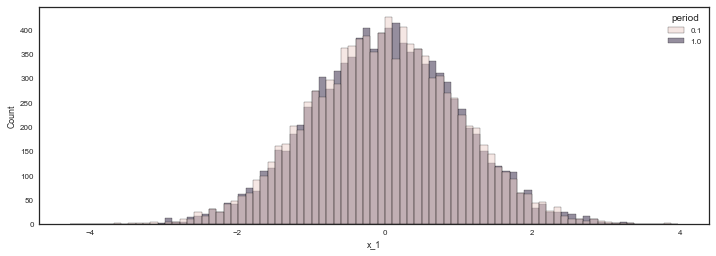

In [9]:
sns.histplot(data=data, x="x_1", hue="period")

<AxesSubplot:xlabel='x_2', ylabel='Count'>

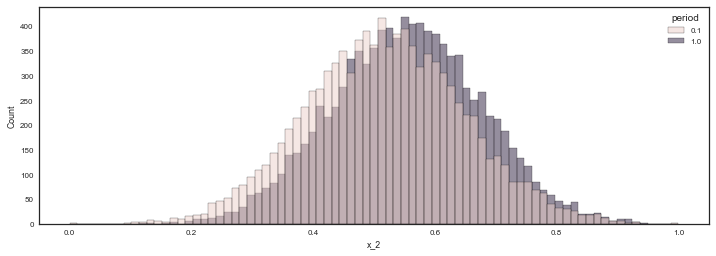

In [10]:
sns.histplot(data=data, x="x_2", hue="period")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]].values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(40000, 3)
(10000,)
(10000,)
(40000,)


In [12]:
time_tree_period_column = "period"

model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=30,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=100,
                                 verbose=False)

In [13]:
model_challenger.feature_importance

x_1    29
x_2     5
Name: Feature Importance, dtype: int64

As we increase `min_sample_periods`, the algorithm picks only x_1, as it becomes less likely we can find invariant x_2 in the different periods with a higher volume of data. 

## What if we have change in variance, but guarantee same support

In [14]:
periods = [0.1, 1]
population_dict = {str(periods[0]): 8 * int(POPULATION / 10),
                   str(periods[1]): 2 * int(POPULATION / 10)}

In [16]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([population_dict[str(period)] * [period] for period in periods],
                                axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

x_2_period_function = {"0.1": -1 * data[data["period"] == 0.1]["y"].values + np.random.normal(0, 0.1, size=population_dict["0.1"]),
                       "1": np.random.normal(0, 1, size=population_dict["1"])}

for period in periods:
    data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]
    
unseen_environments = [0.05, 0.02, 0.5, 1.2]
unseen_data = pd.DataFrame()
unseen_data["period"] = np.concatenate([int(POPULATION/4) * [period] for period in unseen_environments],
                               axis=0)
unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)    

In [18]:
data["Period (environment)"] = data["period"].apply(lambda x: 1 if x == 0.1 else 2)

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

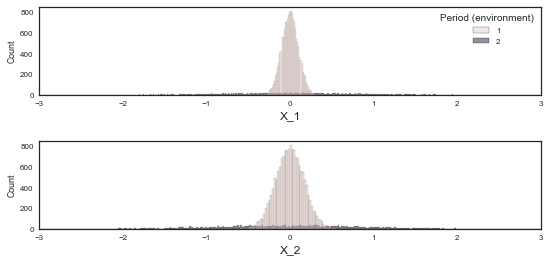

In [19]:
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# sns.histplot(data=data, x="x_1", hue="Period (environment)", ax=axs[0], color=["blue", "green"])
# axs[0].set_xlabel("X_1", fontsize=12)
# axs[0].set_xlim([-3, 3])


# sns.histplot(data=data, x="x_2", hue="Period (environment)", ax=axs[1])
# axs[1].set_xlabel("X_2", fontsize=12)
# axs[1].set_xlim([-3, 3])

# xmin, xmax, ymin, ymax = plt.axis()


# plt.subplots_adjust(hspace=0.4)
# fig.tight_layout(pad=2)
# plt.legend(fontsize=18, bbox_to_anchor=(1.0, 1.0))

# plt.savefig('../images/synthetic_support_problem.eps', format='eps')

<AxesSubplot:xlabel='x_1', ylabel='y'>

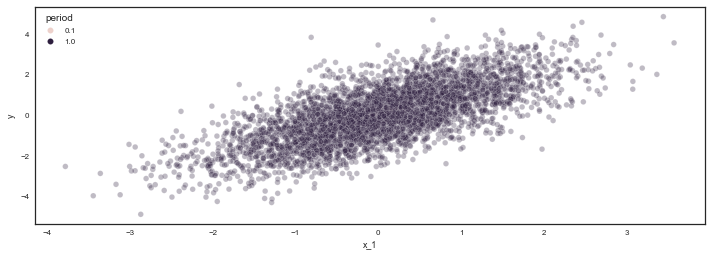

In [20]:
sns.scatterplot(data=data, x="x_1", hue="period", y="y", alpha=0.3)

<AxesSubplot:xlabel='x_2', ylabel='y'>

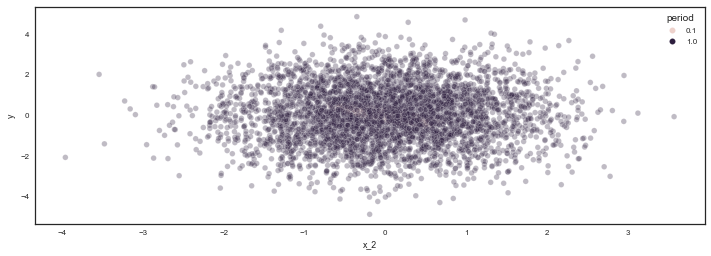

In [21]:
sns.scatterplot(data=data, x="x_2", hue="period", y="y", alpha=0.3)

<AxesSubplot:xlabel='x_1', ylabel='y'>

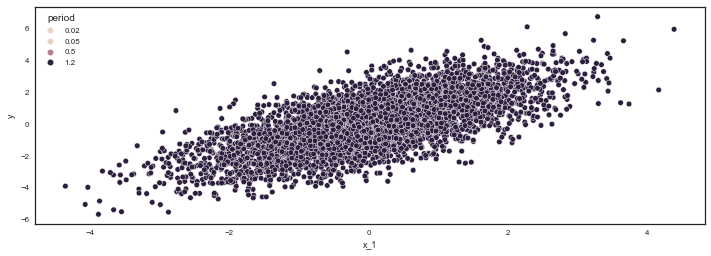

In [22]:
sns.scatterplot(data=unseen_data, x="x_1", hue="period", y="y")

In [23]:
for period in periods:
    mm = MinMaxScaler()
    data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]
    data.loc[data["period"] == period, "y"] = mm.fit_transform(data[data["period"] == period][["y"]])[:, 0]
    
for period in unseen_environments:
    mm = MinMaxScaler()
    unseen_data.loc[unseen_data["period"] == period, "x_1"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_1"]])[:, 0]
    unseen_data.loc[unseen_data["period"] == period, "x_2"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_2"]])[:, 0]    
    unseen_data.loc[unseen_data["period"] == period, "y"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["y"]])[:, 0]    

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]]#.values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test#.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(20000, 3)
(10000,)
(10000,)
(20000,)


In [25]:
time_tree_period_column = "period"

model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=7,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=200,
                                 verbose=True)

Depth: 0
Max Depth: 7
Node periods distribution
0.1    8000
1.0    2000
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1    4160
1.0     970
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1    1243
1.0     296
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1    2917
1.0     674
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1    1559
1.0     367
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1    1358
1.0     307
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1    3840
1.0    1030
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1    2877
1.0     715
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1    1284
1.0     201
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1    1593
1.0     514
Name: period, dtype: int64
Depth: 4
M

In [26]:
model_challenger.feature_importance

x_1    4
x_2    2
Name: Feature Importance, dtype: int64

In [27]:
model_challenger.predict(X_unseen[features])

array([0.66656569, 0.37102799, 0.5111147 , ..., 0.61353517, 0.66656569,
       0.5111147 ])

In [33]:
model.feature_importance()

x_2    8
x_1    7
Name: Feature Importance, dtype: int64

More regularization is needed, but it gets there. 

In [34]:
time_tree_period_column = "period"

model_benchmark = DecisionTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=7,
                                 min_leaf=200,
                                 verbose=True,
                                 time_column="period")

Depth: 0
Max Depth: 7
Node periods distribution
0.1    8000
1.0    2000
Name: period, dtype: int64
Depth: 1
Max Depth: 7
Node periods distribution
0.1    3930
1.0     919
Name: period, dtype: int64
Depth: 2
Max Depth: 7
Node periods distribution
0.1    2379
1.0     635
Name: period, dtype: int64
Depth: 3
Max Depth: 7
Node periods distribution
0.1    2379
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1    650
Name: period, dtype: int64
Depth: 5
Max Depth: 7
Node periods distribution
0.1    248
Name: period, dtype: int64
Depth: 5
Max Depth: 7
Node periods distribution
0.1    402
Name: period, dtype: int64
Depth: 6
Max Depth: 7
Node periods distribution
0.1    201
Name: period, dtype: int64
Depth: 6
Max Depth: 7
Node periods distribution
0.1    201
Name: period, dtype: int64
Depth: 4
Max Depth: 7
Node periods distribution
0.1    1729
Name: period, dtype: int64
Depth: 5
Max Depth: 7
Node periods distribution
0.1    1086
Name: period, dtype: int64
Depth: 6
Max

### Building a curve

<AxesSubplot:xlabel='x_1', ylabel='y'>

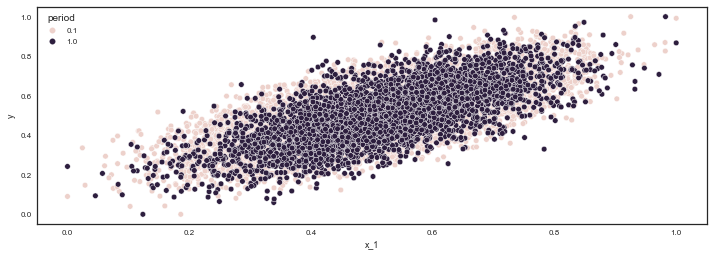

In [35]:
sns.scatterplot(data=data, x="x_1", hue="period", y="y")

<AxesSubplot:xlabel='x_2', ylabel='y'>

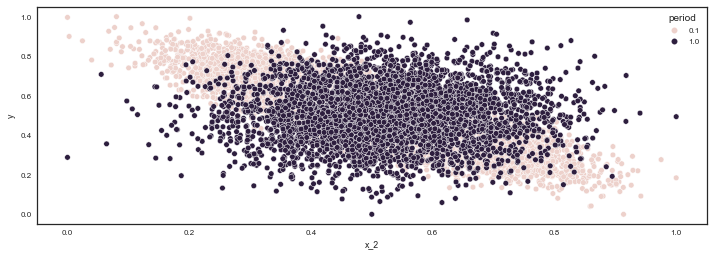

In [36]:
sns.scatterplot(data=data, x="x_2", hue="period", y="y")

<AxesSubplot:xlabel='x_1', ylabel='Count'>

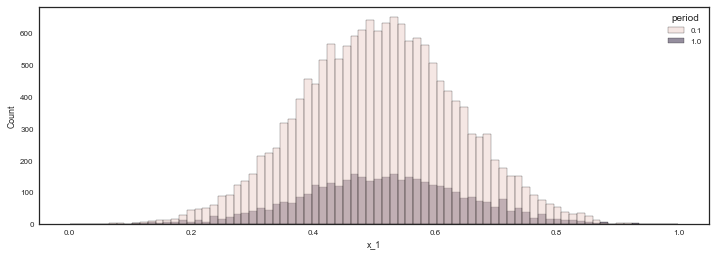

In [37]:
sns.histplot(data=data, x="x_1", hue="period")

<AxesSubplot:xlabel='x_2', ylabel='Count'>

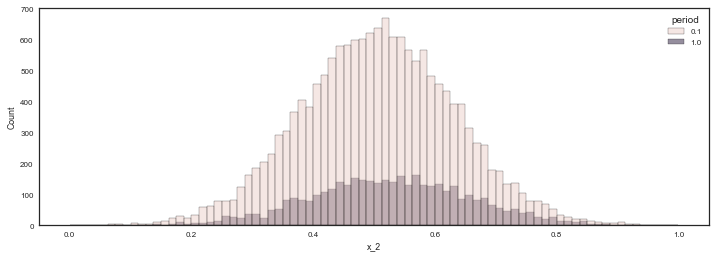

In [38]:
sns.histplot(data=data, x="x_2", hue="period")

<AxesSubplot:xlabel='y', ylabel='Count'>

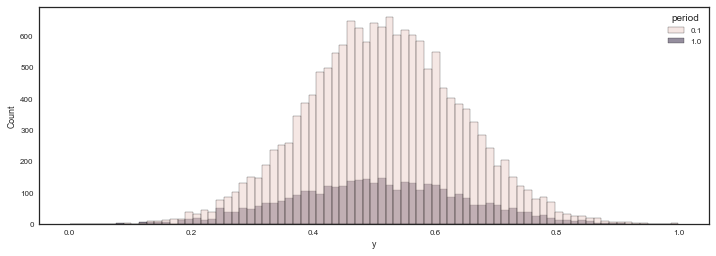

In [39]:
sns.histplot(data=data, x="y", hue="period")

<AxesSubplot:xlabel='y', ylabel='Count'>

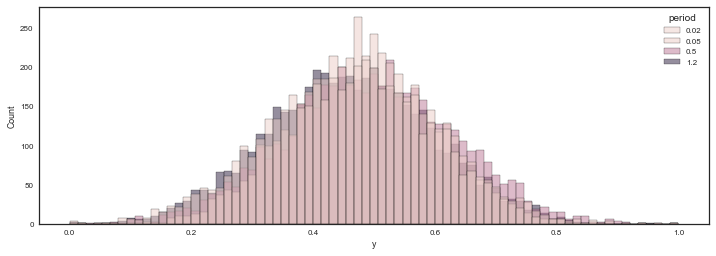

In [40]:
sns.histplot(data=unseen_data, x="y", hue="period")

In [41]:
min_sample_by_period_range = np.linspace(2, 3000, 30, dtype=int)

In [42]:
y_train.mean()

0.5127468670185855

In [43]:
mean_squared_error(y_unseen, [y_train.mean()] * len(y_unseen))

0.019579671855293232

In [44]:
importances = []
performances = []
test_performances = []
bench_performances = []
bench_test_performances = []
bench_importances = []
max_depth = 5

for min_sample in min_sample_by_period_range:
    model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=max_depth,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 min_leaf=min_sample,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=min_sample,
                                 verbose=False)
    
    imp = model_challenger.feature_importance
    
    imp = imp / sum(imp)
    df = pd.DataFrame(imp).transpose()

    df["min_sample"] = min_sample
    importances.append(df)
    
    performances.append(mean_squared_error(y_unseen, model_challenger.predict(X_unseen[features])))
    test_performances.append(mean_squared_error(y_test, model_challenger.predict(X_test[features])))
    
    model = DecisionTree(X_train[features].reset_index(drop=True),
                         y_train.values, max_depth=max_depth, min_leaf=min_sample)
    bench_performances.append(mean_squared_error(y_unseen, model.predict(X_unseen[features])))
    bench_test_performances.append(mean_squared_error(y_test, model.predict(X_test[features])))
    
    imp = model.feature_importance
    
    imp = imp / sum(imp)
    df = pd.DataFrame(imp).transpose()

    df["min_sample"] = min_sample
    bench_importances.append(df)

In [45]:
bench_importances_by_param = pd.concat(bench_importances)
bench_importances_by_param.index = bench_importances_by_param["min_sample"]
bench_importances_by_param.drop(columns=["min_sample"], inplace=True)
bench_importances_by_param.fillna(0, inplace=True)
bench_importances_by_param

,x_2,x_1
min_sample,,
2,0.555556,0.444444
105,0.511111,0.488889
208,0.470588,0.529412
312,0.454545,0.545455
415,0.470588,0.529412
518,0.500000,0.500000
622,0.416667,0.583333
725,0.555556,0.444444
829,0.444444,0.555556


In [46]:
importances_by_param = pd.concat(importances)
importances_by_param.index = importances_by_param["min_sample"]
importances_by_param.drop(columns=["min_sample"], inplace=True)
importances_by_param.fillna(0, inplace=True)
importances_by_param["performance"] = performances
importances_by_param["bench_performance"] = bench_performances
importances_by_param["test_performance"] = test_performances
importances_by_param["bench_test_performance"] = bench_test_performances
importances_by_param

,x_2,x_1,LEAF,performance,bench_performance,test_performance,bench_test_performance
min_sample,,,,,,,
2,0.596774,0.403226,0.0,0.015199,0.015310,0.006723,0.006593
105,0.615385,0.384615,0.0,0.015133,0.015383,0.007570,0.006601
208,0.333333,0.666667,0.0,0.013763,0.015081,0.008253,0.006702
312,0.400000,0.600000,0.0,0.013635,0.015037,0.008440,0.006970
415,0.000000,1.000000,0.0,0.012077,0.015218,0.009663,0.007146
518,0.000000,1.000000,0.0,0.014185,0.015429,0.011636,0.007221
622,0.000000,1.000000,0.0,0.014185,0.014984,0.011636,0.007318
725,0.000000,1.000000,0.0,0.014185,0.016555,0.011636,0.007541
829,0.000000,1.000000,0.0,0.014185,0.015249,0.011636,0.007514


In [47]:
importances_by_param.iloc[importances_by_param["test_performance"].argmin(), :]

x_2                       0.596774
x_1                       0.403226
LEAF                      0.000000
performance               0.015199
bench_performance         0.015310
test_performance          0.006723
bench_test_performance    0.006593
Name: 2, dtype: float64

In [48]:
importances_by_param.iloc[importances_by_param["bench_test_performance"].argmin(), :]

x_2                       0.596774
x_1                       0.403226
LEAF                      0.000000
performance               0.015199
bench_performance         0.015310
test_performance          0.006723
bench_test_performance    0.006593
Name: 2, dtype: float64

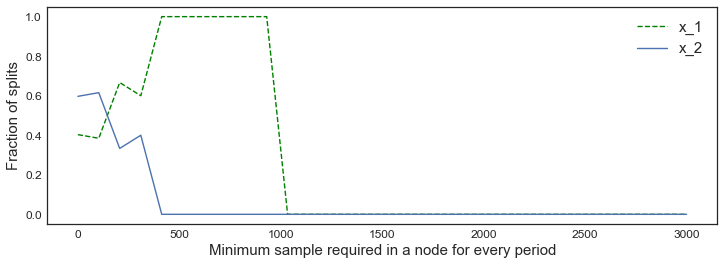

In [49]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["x_1"], color="green", linestyle="dashed", label="x_1")
plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Fraction of splits", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_min_sample.eps", format="eps", bbox_inches="tight")

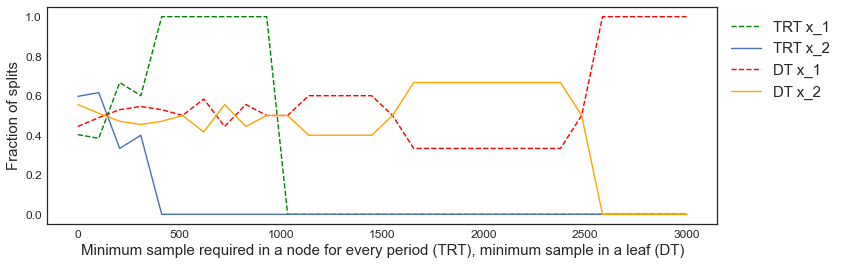

In [66]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["x_1"], color="green", linestyle="dashed", label="TRT x_1")
plt.plot(importances_by_param["x_2"], label="TRT x_2", color="#4c72b0")

plt.plot(bench_importances_by_param["x_1"], color="red", linestyle="dashed", label="DT x_1")
plt.plot(bench_importances_by_param["x_2"], label="DT x_2", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Fraction of splits", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period (TRT), minimum sample in a leaf (DT)", fontsize=15)
plt.savefig("../images/synthetic_min_sample_dt.eps", format="eps", bbox_inches="tight")

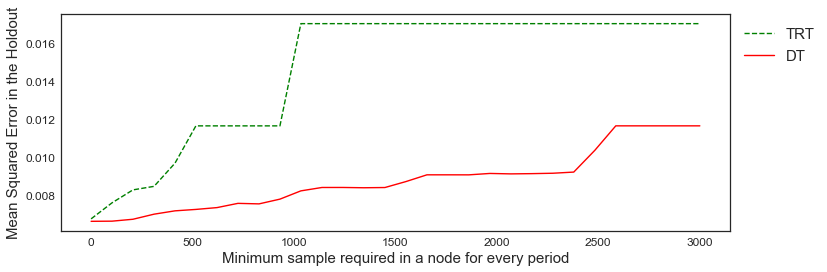

In [51]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["test_performance"], color="green", linestyle="dashed", label="TRT")
plt.plot(importances_by_param["bench_test_performance"], color="red", label="DT")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error in the Holdout", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance_test.eps", format="eps", bbox_inches="tight")

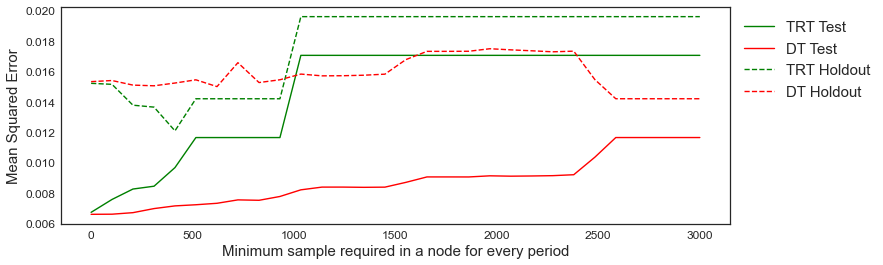

In [52]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["test_performance"], color="green", label="TRT Test")
plt.plot(importances_by_param["bench_test_performance"], color="red", label="DT Test")

plt.plot(importances_by_param["performance"], color="green", linestyle="dashed", label="TRT Holdout")
plt.plot(importances_by_param["bench_performance"], color="red", linestyle="dashed", label="DT Holdout")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance_both.eps", format="eps", bbox_inches="tight")

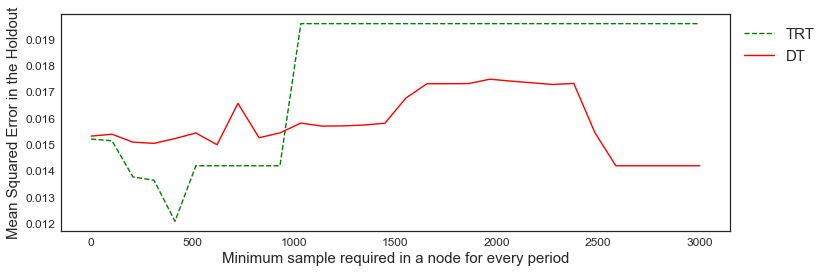

In [64]:
fig, ax = plt.subplots()
plt.plot(importances_by_param["performance"], color="green", linestyle="dashed", label="TRT")
plt.plot(importances_by_param["bench_performance"], color="red", label="DT")
#plt.plot(importances_by_param["x_2"], label="x_2", color="#4c72b0")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error in the Holdout", fontsize=15)
plt.xlabel("Minimum sample required in a node for every period", fontsize=15)
plt.savefig("../images/synthetic_performance_holdout.eps", format="eps", bbox_inches="tight")

In [54]:
importances_by_param["performance"].min()

0.012076680833950613

In [55]:
importances_by_param["bench_performance"].min()

0.01418585328136555

## Bootstrapping with different proportions from t=1 and t=2

In [56]:
def create_dataset(w_1, w_2, population=1000):
    population_dict = {"0.1": w_1 * int(population / (w_1 + w_2)),
                       "1": w_2 * int(population / (w_1 + w_2))}
    periods = [0.1, 1]
    data = pd.DataFrame()
    data["period"] = np.concatenate([population_dict[str(period)] * [period] for period in periods],
                                    axis=0)
    data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
    data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)

    x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values + np.random.normal(0, 0.1, size=population_dict["0.1"]),
                           "1": np.random.normal(0, 1, size=population_dict["1"])}

    x_2_period_function = {"0.1": data[data["period"] == 0.1]["y"].values,
                           "1": np.random.normal(0, 1, size=population_dict["1"])}

    for period in periods:
        data.loc[data["period"] == period, "x_2"] = x_2_period_function[str(period)]
        
    
    for period in periods:
        mm = MinMaxScaler()
        data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
        data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]
    
    periods = [0.05, 0.02, 0.5, 1.2]
    unseen_environments = periods
    unseen_data = pd.DataFrame()
    unseen_data["period"] = np.concatenate([population * [period] for period in periods],
                                   axis=0)
    unseen_data["x_1"] = unseen_data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
    unseen_data["y"] = unseen_data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
    unseen_data["x_2"] = unseen_data.apply(lambda x: np.random.normal(0, 1), axis=1)

    for period in unseen_environments:
        mm = MinMaxScaler()
        unseen_data.loc[unseen_data["period"] == period, "x_1"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_1"]])[:, 0]
        unseen_data.loc[unseen_data["period"] == period, "x_2"] = mm.fit_transform(unseen_data[unseen_data["period"] == period][["x_2"]])[:, 0]    
        
    X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                        data[target],
                                                        test_size=0.5,
                                                        stratify=data[environment],
                                                        random_state=42)

    X_unseen = unseen_data[features + [environment]]#.values
    y_unseen = unseen_data[target]

    X = X_train[["x_1", "x_2", "period"]].values
    X_test = X_test#.values
    y = y_train.values     
    
    return X_train.reset_index(drop=True), X_test, y, y_test, unseen_data

In [57]:
experiment_results = {}
experiment_results["result"] = {"benchmark": [], 
                                "challenger": []}  
n_rounds = 50
min_leafs = list(np.linspace(2, 550, 25, dtype=int))

for n_round in range(n_rounds):
    experiment_results[n_round] = {"benchmark": {}, 
                                   "challenger": {}}    
    weights = np.random.randint(1, 10, 2)
    X_train, X_test, y, y_test, unseen_data = create_dataset(weights[0],
                                                             weights[1])

    

    for model_type in ["benchmark", "challenger"]:
        experiment_results[n_round][model_type]["df"] = []
        experiment_results[n_round][model_type]["train"] = []
        experiment_results[n_round][model_type]["holdout"] = []
        experiment_results[n_round][model_type]["splits"] = []   
        
        
    for min_leaf in min_leafs:
        ### Benchmark model
        model_type = "benchmark"
        model = DecisionTree(X_train[["x_1", "x_2"]], y, max_depth=20, min_leaf=min_leaf)
        X_train["prediction"] = model.predict(X_train[features])
        n_splits = model.feature_importance.sum()
        experiment_results[n_round][model_type]["splits"].append(min_leaf)
        unseen_data["prediction"] = model.predict(unseen_data[features])
        experiment_results[n_round][model_type]["train"].append(mean_squared_error(y, X_train["prediction"]))
        experiment_results[n_round][model_type]["holdout"].append(mean_squared_error(unseen_data[target], 
                                                                                unseen_data["prediction"]))
        
 
        ### Challenger model
        model_type = "challenger"
        time_model_tree = RandomTimeSplitTree(X_train[["x_1", "x_2", "period"]], 
                                            y,
                                            time_column="period",
                                            max_depth=20,
                                            min_sample_periods=int(min_leaf/2),
                                            min_leaf=min_leaf,  
                                            verbose=False,
                                            split_verbose=False,
                                            bootstrapping=False,
                                            max_features=1.0,
                                            period_criterion="max")
        X_train["time_prediction"] = time_model_tree.predict(X_train)

        n_splits = time_model_tree.feature_importance.sum()
        experiment_results[n_round][model_type]["splits"].append(min_leaf)
        unseen_data["time_prediction"] = time_model_tree.predict(unseen_data[features])
        experiment_results[n_round][model_type]["train"].append(mean_squared_error(y, X_train["time_prediction"]))
        experiment_results[n_round][model_type]["holdout"].append(mean_squared_error(unseen_data[target], unseen_data["time_prediction"]))
        
    benchmark_df = pd.DataFrame(list(zip(experiment_results[n_round]["benchmark"]["train"],
                                experiment_results[n_round]["benchmark"]["holdout"],
                                experiment_results[n_round]["benchmark"]["splits"])), 
                                columns=["train", "holdout", "splits"])
    
    challenger_df = pd.DataFrame(list(zip(experiment_results[n_round]["challenger"]["train"],
                                 experiment_results[n_round]["challenger"]["holdout"],
                                 experiment_results[n_round]["challenger"]["splits"])), 
                                 columns=["train", "holdout", "splits"])
    
    benchmark_df.loc[:, "weight"] = str(weights)
    challenger_df.loc[:, "weight"] = str(weights)
    
    experiment_results["result"]["benchmark"].append(benchmark_df)
    experiment_results["result"]["challenger"].append(challenger_df)

In [58]:
benchmark_results = pd.concat(experiment_results["result"]["benchmark"])
benchmark_results["model"] = "benchmark"

challenger_results = pd.concat(experiment_results["result"]["challenger"])
challenger_results["model"] = "challenger"    

../images/synthetic_boot:22: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.


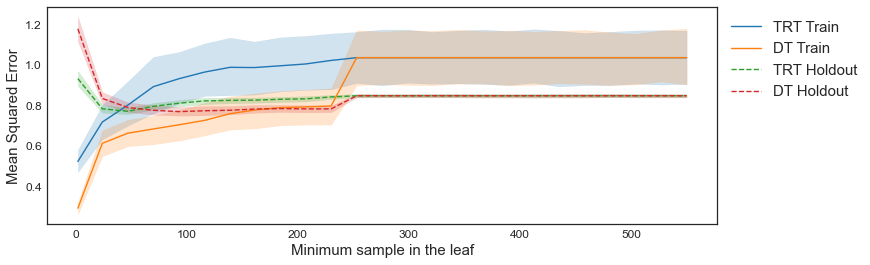

In [59]:
from matplotlib.collections import PolyCollection as p

fig, ax = plt.subplots()
sns.lineplot(data=challenger_results, x="splits", y="train", label="TRT Train")
sns.lineplot(data=benchmark_results, x="splits", y="train", label="DT Train")

sns.lineplot(data=challenger_results, x="splits", y="holdout", linestyle="dashed", label="TRT Holdout")
sns.lineplot(data=benchmark_results, x="splits", y="holdout", linestyle="dashed", label="DT Holdout")
plt.legend()

xmin, xmax, ymin, ymax = plt.axis()

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Mean Squared Error", fontsize=15)
#plt.xlabel("Minimum sample in the leaf (DT), minimum sample by period (TRT)", fontsize=15)
plt.xlabel("Minimum sample in the leaf", fontsize=15)

__file__ = "../images/synthetic_boot"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")

## What if X_2 doesn't change during the training time?

In [60]:
periods = [0.1, 1]
data = pd.DataFrame()
data["period"] = np.concatenate([int(POPULATION/2) * [period] for period in periods],
                               axis=0)
data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["period"], axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1) * x["period"], axis=1)
data["x_2"] = data.apply(lambda x: x["y"] + np.random.normal(0, 1), axis=1)

for period in periods:
    mm = MinMaxScaler()
    data.loc[data["period"] == period, "x_1"] = mm.fit_transform(data[data["period"] == period][["x_1"]])[:, 0]
    data.loc[data["period"] == period, "x_2"] = mm.fit_transform(data[data["period"] == period][["x_2"]])[:, 0]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data[features + [environment]], 
                                                    data[target],
                                                    test_size=0.5,
                                                    stratify=data[environment],
                                                    random_state=42)

X_unseen = unseen_data[features + [environment]].values
y_unseen = unseen_data[target]

X = X_train[["x_1", "x_2", "period"]].values
X_test = X_test.values
y = y_train.values

print(X_train.shape)
print(X_test.shape)
print(X_unseen.shape)
print(y_train.shape)
print(y_test.shape)
print(y_unseen.shape)

(10000, 3)
(10000, 3)
(4000, 3)
(10000,)
(10000,)
(4000,)


In [62]:
model_challenger = RandomTimeSplitTree(X_train[features + [time_tree_period_column]].reset_index(drop=True),
                                 y_train.values,
                                 max_depth=30,
                                 max_features=1.0,
                                 bootstrapping=False,
                                 time_column=time_tree_period_column,
                                 min_sample_periods=100,
                                 verbose=False)

In [63]:
model_challenger.feature_importance

x_2    17
x_1    10
Name: Feature Importance, dtype: int64

It's unable to solve the exact same case from IRM, it depends on changes in the spurious variable during the training time.